In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, \
                                        BatchNormalization, Embedding, Masking, Bidirectional, Conv1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.utils import class_weight, shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBRegressor, XGBClassifier

import scipy.stats as stats
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
BATCH_SIZE = 32
EPOCHS = 300

from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import cx_Oracle
import pandas as pd
from sqlalchemy import create_engine
from imblearn.over_sampling import SMOTE
from collections import Counter
import shap

class Aggregate_helper:
    def __init__(self, eq_id, lookback_window, major_down_hour, alarm_table):
        self.eq_id = eq_id
        self.lookback_window = lookback_window
        self.major_down_hour = major_down_hour
        self.alarm_table = alarm_table
        self.status_table = self.query_status()
        
        ## include all status instead since further preprocessing would be performed
        ## make sure that the timeframe table is a subset of both the alarm and status table to compute major down correctly
        time1 = self.alarm_table.iloc[0]["DT_SET"]
        time2 = self.status_table.iloc[0]["TIMESTAMP_START"]
        timeend1 = self.alarm_table.iloc[len(self.alarm_table)-1]["DT_SET"]
        timeend2 = self.status_table.iloc[len(self.status_table)-1]["TIMESTAMP_START"]
        
        # give a 3 days window to ensure that the alarm and status are captured fully
        start = (max(time1, time2) + timedelta(days=3)).strftime("%d/%m/%Y") 
        end = min(timeend1, timeend2).strftime("%d/%m/%Y")
        
        self.timeframe_table = self.generate_time(start, end, 3)
        self.major_down_arr = self.major_down(self.timeframe_table, self.status_table, self.major_down_hour, 3600)
        self.aggregated_table = self.aggregate(self.timeframe_table, self.lookback_window, self.alarm_table, self.status_table)
        
        
    def generate_time(self, start_date:str, end_date:str, hour:int):
        start = datetime.strptime(start_date, '%d/%m/%Y')
        end = datetime.strptime(end_date, '%d/%m/%Y')

        dates = []
        while start<=end:
            row = [start]
            dates.append(row)
            start += timedelta(hours=hour)

        return pd.DataFrame(dates, columns=['TIMESTAMP'])
    
    def query_status(self):
        try:
            oracle_string = "oracle+cx_oracle://{username}:{password}@{hostname}:{port}/{database}"
            engine = create_engine(
                oracle_string.format(
                    username = 'TFM4CEBERUS',
                    password = 'TFM4CEBERUS',
                    hostname = 'ome-db.bth.infineon.com',
                    port = '1538',
                    database = 'ome'
                    )
                )
        except Exception as e:
            print(str(e))

        query = f"""select EQ_ID, TIMESTAMP_START, TIMESTAMP_END, DURATION, STATE_NAME, LEVEL3_NAME, LEVEL3 
                from (SELECT
                  eq.eq_id, eq.name, eq.eq_type_ident
                , data.timestamp_start,data.timestamp_end
                , ROUND((data.timestamp_end - data.timestamp_start)*24*60*60,0) AS Duration
                , data.tr25_3_status,data.tr25_4_status,data.tr25_5_status,data.eq_status
                , level5s.state_name
                , level5.state_name Level5_Name, level5.state_sign Level5
                , level4.state_name Level4_Name, level4.state_sign Level4
                , level3.state_name Level3_Name, level3.state_sign Level3
                ,mh.device
                ,mh.package,
                mh.lotid as lot,
                mh.product,
                mh.operation

                FROM OMEDATA.EQUIPMENT_STATE_HISTORY data
                , OMEADMIN.EQUIPMENT_INSTANCES eq
                , V_EQ_STATES level5s
                , OMEADMIN.DEF_STANDARD_STATEMODEL level5
                , OMEADMIN.DEF_STANDARD_STATEMODEL level4
                , OMEADMIN.DEF_STANDARD_STATEMODEL level3
                , OMEDATA.METAKEY_HISTORY mh

                WHERE data.eq_ident  = eq.eq_ident
                AND  data.eq_status = level5s.state_ident(+)
                AND level5.state_ident = data.tr25_5_status
                AND level4.state_ident = data.tr25_4_status
                AND level3.state_ident = data.tr25_3_status
                AND  data.metakey_ident =mh.ident(+)
                and data.timestamp_start > sysdate - 1050)
                where eq_id = '{self.eq_id}'
                ORDER BY TIMESTAMP_START"""

        status = pd.read_sql(query, engine)
        status.columns = map(lambda x: str(x).upper(), status.columns) 

        return status
    
    def aggregate(self, timeframe_table, lookback_window, alarm_table, status_table):
        alarm_df = pd.DataFrame()
        statename_df = pd.DataFrame()

        for idx, row in timeframe_table.iterrows():
            end = row["TIMESTAMP"]
            start = end - timedelta(hours=lookback_window)

            ## count the frequencies of each alarm
            filtered_alarm = alarm_table.loc[(alarm_table["DT_SET"] >= start) & (alarm_table["DT_SET"] <= end)]
            alarm_freq_table = filtered_alarm["Alarm ID"].value_counts().to_frame().T.reset_index(drop=True)
            alarm_df = pd.concat([alarm_df, alarm_freq_table], axis=0)

            ## count the frequencies of each statename, include everything since feature engineering would be performed
            filtered_statename = status_table.loc[(status_table["TIMESTAMP_START"] >= start) & (status_table["TIMESTAMP_START"] <= end)]
            status_freq_table = filtered_statename["STATE_NAME"].value_counts().to_frame().T.reset_index(drop=True)
            statename_df = pd.concat([statename_df, status_freq_table], axis=0)

        df = pd.concat([alarm_df, statename_df], axis=1)
        df = df.fillna(0)

        ## convert all columns from float to int
        cols = df.columns
        df[cols] = df[cols].astype(int)
        return df
        
    def major_down(self, input_df, status_table, hour, threshold):
        hour = pd.Timedelta(hours=hour)
        major_down = []

        for idx, row in input_df.iterrows():
            start = row['TIMESTAMP']
            end = start+hour
            frame = status_table[(status_table['TIMESTAMP_START']>start) & (status_table['TIMESTAMP_START']<end)]
            UD = frame.loc[frame['LEVEL3']=='UDT']

            if len(UD) == 0: #no record within this 6 hours:
                major_down.append(0)
            else:
                time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
                if any(time_diff>threshold):
                    major_down.append(1)
                else:
                    major_down.append(0)
        return np.array(major_down)

In [2]:
def train_val_test_split(training, target):
    X_train, X_val, y_train, y_val =  train_test_split(training, target, test_size=0.3, random_state=42, shuffle=True, stratify=target)
    X_val, X_test, y_val, y_test =  train_test_split(X_val, y_val, test_size=0.4, random_state=42, shuffle=True, stratify=y_val)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [9]:
wba123_fullalarm = pd.read_excel("Data/WBA123_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
wba123 = Aggregate_helper("WBA123", 24, 24, wba123_fullalarm)

wba124_fullalarm = pd.read_excel("Data/WBA124_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
wba124 = Aggregate_helper("WBA124", 24, 24, wba124_fullalarm)

wba126_fullalarm = pd.read_excel("Data/WBA126_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
wba126 = Aggregate_helper("WBA126", 24, 24, wba126_fullalarm)

wba127_fullalarm = pd.read_excel("Data/WBA127_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
wba127 = Aggregate_helper("WBA127", 24, 24, wba127_fullalarm)

wba128_fullalarm = pd.read_excel("Data/WBA128_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
wba128 = Aggregate_helper("WBA128", 24, 24, wba128_fullalarm)

TypeError: __init__() takes 4 positional arguments but 5 were given

In [ ]:
all_tables = [wba123.aggregated_table, wba124.aggregated_table, wba126.aggregated_table, wba127.aggregated_table, wba128.aggregated_table]
new_training = pd.concat(all_tables, axis=0)
new_training = new_training.fillna(0)

## convert all columns from float to int
cols = new_training.columns
new_training[cols] = new_training[cols].astype(int)

all_target = (wba123.major_down_arr, wba124.major_down_arr, wba126.major_down_arr, wba127.major_down_arr, wba128.major_down_arr)
new_target = np.concatenate(all_target)

print(Counter(new_target))

oversample = SMOTE()
smote_X, smote_y = oversample.fit_resample(new_training.values, new_target)
print(Counter(smote_y))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(smote_X, smote_y, test_size=0.3)

## Uncomment this block if you wish to remove features using ANOVA

In [ ]:
# all_tables = [wba123.aggregated_table, wba124.aggregated_table, wba126.aggregated_table, wba127.aggregated_table, wba128.aggregated_table]
# new_training = pd.concat(all_tables, axis=0)
# new_training = new_training.fillna(0)

# ## convert all columns from float to int
# cols = new_training.columns
# new_training[cols] = new_training[cols].astype(int)

# all_target = (wba123.major_down_arr, wba124.major_down_arr, wba126.major_down_arr, wba127.major_down_arr, wba128.major_down_arr)
# new_target = np.concatenate(all_target)

# print(Counter(new_target))

# oversample = SMOTE()
# new_training, new_target = oversample.fit_resample(new_training.values, new_target)
# print(Counter(new_target))

# # used to find out the column names
# all_tables = [wba123.aggregated_table, wba124.aggregated_table, wba126.aggregated_table, wba127.aggregated_table, wba128.aggregated_table]
# new_table = pd.concat(all_tables, axis=0)

# df = pd.DataFrame(new_training, columns=new_table.columns)
# df["MajorDown"] = new_target

# groups = df.groupby("MajorDown").groups # returns the index of rows under each group

# # Extract data in each group
# down = df.loc[groups[1]]
# no_down = df.loc[groups[0]]

# # Perform ANOVA 
# f, p = stats.f_oneway(down, no_down)[0], stats.f_oneway(down, no_down)[1]

# df_removed = df.copy()
# cols_remove = df.columns[np.where(p>=0.05)[0]].values
# df_removed = df_removed.drop(cols_remove, axis=1)

# removed_training = df_removed.iloc[:,0:106].values
# removed_target = df_removed.iloc[:,106].values

# removed_training, removed_target = shuffle(removed_training, removed_target)
# print(Counter(removed_target))

# X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(removed_training, removed_target)

In [ ]:
param = {"n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
           "max_depth": [int(x) for x in np.linspace(10, 110, 11)],
           "min_samples_split": [2, 5, 10],
           "min_samples_leaf": [1, 2, 4]}

model = RandomForestClassifier(random_state=42)

start = datetime.now()
search = RandomizedSearchCV(model, param, cv=5, n_jobs=-1, scoring='f1')
search.fit(X_train, y_train)
model = search.best_estimator_
pred = model.predict(X_test)

end = datetime.now()

print(f"Training took {(end-start).seconds} seconds")
print(confusion_matrix(y_test, pred))
print(f"Prediction Accuracy for {type(model).__name__} is {accuracy_score(y_test, pred)}")

In [18]:
dt_model = DecisionTreeClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42, oob_score=True)

models = [rf_model]
for model in models:
    start = datetime.now()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    end = datetime.now()
    print(f"Training took {(end-start).seconds} seconds")
    print(confusion_matrix(y_test, pred))
    print(f"Prediction Accuracy for {type(model).__name__} is {accuracy_score(y_test, pred)}")
    print(f"Training score: ", model.score(X_train, y_train))
    print(f"OOB score: ", model.oob_score_)
    

Training took 11 seconds
[[10026   708]
 [  767 10074]]
Prediction Accuracy for RandomForestClassifier is 0.9316338354577057
Training score:  0.9822602753332407
OOB score:  0.9264387453068198


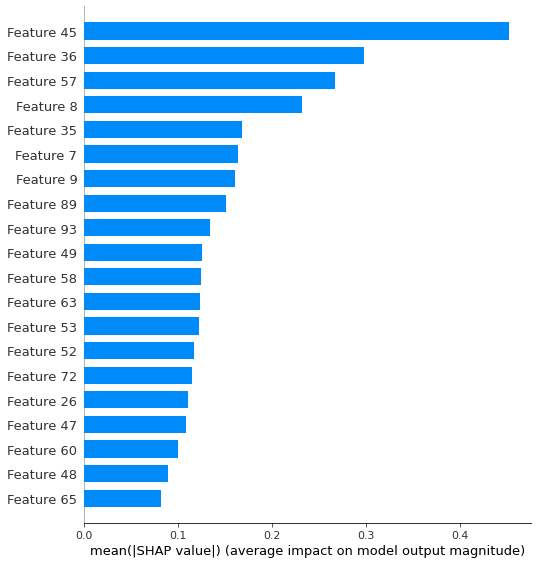

In [11]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)

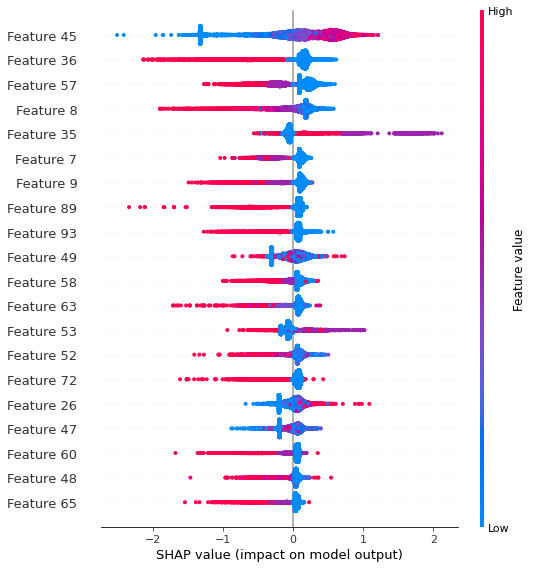

In [13]:
shap.summary_plot(shap_values, X_test)

In [66]:
new_test_set = X_test[-25]
new_test_y = y_test[-25]

new_test_set = new_test_set.reshape(1, new_test_set.shape[0])
new_test_y = np.array(new_test_y)

new_test_set, new_test_y

(array([[ 0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,
          5,  0,  0,  0,  8,  0,  1,  0,  3, 11, 28,  0,  0,  0,  0,  0,
          0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 88, 27, 13,
          9, 28,  0,  1,  6,  0,  0,  1, 14,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]),
 array(0))

In [67]:
one_row = model.predict(new_test_set)

In [68]:
one_row

array([1])

In [69]:
shap_values = shap.TreeExplainer(rf_model).shap_values(new_test_set, check_additivity=False)

In [73]:
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

Exception: In v0.20 force_plot now requires the base value as the first parameter! Try shap.force_plot(explainer.expected_value, shap_values) or for multi-output models try shap.force_plot(explainer.expected_value[0], shap_values[0]).

In [49]:
new_training.columns[52], 

('Visual Inspection',)

In [48]:
new_test_set[0][52]

6